# Model de regresie logistica binara antrenat cu Pytorch

Bibliografie:
1. Deep Learning with PyTorch, Eli Stevens, Luca Antiga, Thomas Viehmann, Manning; 1st edition (August 4, 2020)
1. PyTorch Pocket Reference: Building and Deploying Deep Learning Models, by Joe Papa, O'Reilly Media; 1st edition (June 1, 2021)

Optimizari de performanta: [PYTORCH PERFORMANCE TUNING GUIDE](https://tigress-web.princeton.edu/~jdh4/PyTorchPerformanceTuningGuide_GTC2021.pdf)

## Setul de date MNIST

Setul de date MNIST consta din desenele alb-negru ale cifrelor 0-9 desenate de mana; fiecare cifra este vazuta ca un tensor 3 de forma 1x28x28; primul numar reprezinta numarul de canale. Cateva exemple sunt in figura de mai jos.
![Exemplu set MNIST](./images/mnist.png "Exemplu set MNIST").

## Importarea pachetelor necesare 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.0+cu118  Device: cuda


Pachetul torch-summary este util pentru obtinerea sumarului unui model instruibil: numar de ponderi instruibile, dimensiune etc. 

In [2]:
!pip install torch-summary

In [3]:
from torchsummary import summary

## Pregatirea setului de date: clasa de tip Dataset

Sursa: [Tutorial Dataset & Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataset)

In Pytorch, setul de date este facut disponibil printr-o clasa de tip `Dataset`. Vom face o implementare de clasa `MNISTDataset`care sa citeasca din fisierele CSV aflate in directorul ./data.

Trebuie sa urmam pasii:
1. Clasa noastra `MNISTDataset` se va deriva din clasa `torch.utils.data.Dataset`. Metoda `__init__` va primi locatia fisierului CSV de intrare. Pentru regresia bianra va primi si cifrele pentru care se doreste a se construi un clasificator binar.
1. Pe langa metoda `__init__` vom mai avea doua metode implementate:
    1. metoda `__len__` care returneaza numarul de elemente din setul de date
    1. metoda `__getitem__` care returneaza valoarea de indice specificat. Prin valoare, pentru aceasta problema, ne referim la tuplul: vector de intrare de 784 de componente si eticheta (1 = clasa pozitiva, 0 = clasa negativa)

In [4]:
# importam clasa de bazza Dataset:
from torch.utils.data import Dataset

In [5]:
# pentru citire de fisier cvs, verificare cai etc:
import pandas as pd
import os
from typing import Tuple

In [ ]:
class MNISTDataset(Dataset):
    
    def __init__(self, path_csv: str, positive_class: int, negative_class: int):
        """
        Initializeaza setul de date, folosind o cale catre fisier csv si indicatie despre clasa pozitiva si negativa
        :param path_csv: cale catre fisier CSV care contine date de train sau test
        :param positive_class: indice de clasa pozitiva, numar 0...9
        :param negative_class: indice de clasa negativa, numar 0...9 diferit de :param positive_class:
        """
        # pt clasa derivata se obisnuieste apelul de initializator de clasa parinte 
        super(MNISTDataset, self).__init__()
        assert os.path.exists(path_csv) and os.path.isfile(path_csv), f'Calea {path_csv} nu indica spre un fisier'
        assert 0 <= positive_class <= 9 and 0 <= negative_class <= 9 and positive_class != negative_class
        
        self.x = torch.Tensor(...)
        self.y = torch.Tensor(...)
        
    def __len__(self):
        """
        Returneaza lungimea setului de date curent
        :return: lungimea setului de date
        """
        return len(self.y)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returneaza perechea (intrare, eticheta_asociata) de pe pozitia :param index:
        :param index: pozitia de pe care se returneaza vectorul si clasa lui
        :return: pereche: vector de intarre de 784 de elemente, eticheta clasa 0 sau 1
        """
        return self.x[index, :], self.y[index]

In [7]:
positive_class = 8
negative_class = 4
train_ds = MNISTDataset('./data/mnist_train.csv', positive_class, negative_class)
test_ds = MNISTDataset('./data/mnist_test.csv', positive_class, negative_class)

assert len(train_ds) == 11693
assert len(test_ds) == 1956

## Incarcarea datelor folosind un DataLoader
Sursa: [Tutorial Dataset & Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataset)

Un obiect Dataset da acces la valorile dintr-un set, element cu element. Pentru antrenare se prefera gruparea de mai multe date, pentru a face calculul mai eficient. Un grup da date se numeste minibatch. Gruparea datelor in minibatch-uri este facuta de catre un DataLoader. Acesta primeste parametri precum: 
* obiectul dataset din care preia datele
* dimensiunea minibatch-ului
* daca se doreste amestecarea aleatoare a setului de date
* etc. 

Uneori seturile de date sunt suficient de mici ca sa poate fi incarcate in memoria GPU, pentru calcul de gradienti. De multe ori, insa, seturile sunt prea mari si atunci se prefera impartirea lor in subseturi de date (minibatches). Mai jos folosim minibatch-uri de 32 de date, valoare specificata in parametrii `batch_size`.

In [8]:
from torch.utils.data import DataLoader

In [9]:
batch_size = 32 # in functie de memoria disponibila pe GPU
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# pentru primul minibatch tiparim 'shape'
# datele de intrare ar tb sa fie un tensor de forma (batch_size x 784)
# etichetele ar trebui sa fie un tensor de forma batch_size
for data, label in train_loader:
    print(data.shape, label.shape)
    break
    
# restul de minibatchuri arata la fel, eventual exceptand ultimul minibatch

torch.Size([32, 784]) torch.Size([32])


## Definirea modelului

In Pytorch un model este o clasa derivata din `torch.nn.Module`. Esentiale sunt implementarea de:
* metoda de initializare, `__init__`
* metoda `forward` care preia un minibatch de intrare si produce o estimare

Metoda de initializare construieste ponderile. 

In [10]:
class BinaryLogisticRegression(nn.Module):
    def __init__(self, input_size: int = 784):
        """
        Initializarea unui obiect de tip LogisticRegression
        :param input_size: dimensiunea unui vector de intrare. De ex, pt MINST este 784
        """
        # pt clasa derivata se obisnuieste apelul de initializator de clasa parinte
        super(BinaryLogisticRegression, self).__init__()
        self.input_size = input_size
        # initializam ponderile ca o matrice de input_size x 1 elemente aleatoare
        # matrice = operator liniar
        self.fully_connected = nn.Linear(input_size, 1)

    def forward(self, x):
        # x este un minibatch de exemplu de forma 32x784 (ultimul minibatch poate avea mai putin de 32 de tensori)

        # se propaga dinspre stratul de intrare spre primul strat ascuns
        # aplicarea unei functii liniare este echivalenta cu inmulttirea unei matrice cu intrarea curenta
        x = self.fully_connected(x)
        
        # se aplica functia logistic sigmoid pentru a obtine probabilitatea conditionata
        x = torch.sigmoid(x)
        
        return x

Instantiem modelul:

In [11]:
model = BinaryLogisticRegression(input_size=784)

Tiparim modelul:

In [12]:
print(model)

BinaryLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=1, bias=True)
)


Mai multe detalii se afla cu functia `summary()`:

In [13]:
summary(model);

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            785
Total params: 785
Trainable params: 785
Non-trainable params: 0


Trecem modelul pe device. Daca device=cpu, atunci linia de mai jos nu are niciun efect. Daca device=cuda, atunci modelul este trecut in GPU si rularea va fi mai rapida:

In [14]:
print(f'device={device}')
model.to(device)

device=cuda


BinaryLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=1, bias=True)
)

## Scurt demo: ce prezice modelul pentru primul minibatch din setul de antrenare?

In [ ]:
for x, y in train_loader:
    # datele si modelul trebuie sa fie pe acelasi device, altfel calculele nu se pot efectua
    x, y = x.to(device), y.to(device)
    
    # produce predictia, tensor plin cu probabilitati
    y_hat = ...
    print(f'Predictii (probabilitati): {y_hat}')
    
    # daca probabilitatea conditionata este >= 0.5, atunci modelul prezice clasa pozitiva (1), altfel 0 
    clase = y_hat >= 0.5
    # clase e un vector de booleni; True = 1, False = 0
    print('Cate clase au fost prezise corect: ', (clase == y).sum())
    
    # ne oprim dupa primul minibatch aici, e doar pentru a vedea cum arata predictiile facute de model
    break 

Predictii (probabilitati): tensor([0.4748, 0.5245, 0.5099, 0.4492, 0.5320, 0.4953, 0.5027, 0.5119, 0.5342,
        0.4853, 0.5691, 0.5266, 0.5385, 0.5616, 0.4854, 0.4878, 0.5217, 0.5127,
        0.5689, 0.5118, 0.5345, 0.5276, 0.4945, 0.5561, 0.4509, 0.5362, 0.5466,
        0.4904, 0.5354, 0.4983, 0.5163, 0.4963], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
Cate clase au fost prezise corect:  tensor(17, device='cuda:0')


## Antrenarea modelului

Vom avea mai multe epoci de antrenare. In fiecare epoca:
* se parcurg toate minibatchurile de date din train_loader
* se calculeaza functie de eroare pe minibatch, se calculeaza gradientii, se aplica gradientii pentru modificarea ponderilor
* la finalul fiecarei epoci se ruleaza modelul pe setul de testare, pentru a vedea acuratetea obtinuta

In [16]:
def test(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    """
    Testeaza modelul pe datele furnizate de :param loader:
    :param model: model de regresie logistica binara
    :param loader: un dataloader care furnizeaza datele din setul peset care se testeaza
    :param device: pe ce device se afla modelul (cpu, gpu, tpu etc)
    :return: acuratetea de predictie
    """
    # initializare valori pt statistica
    correctly_classified = 0
    total_items = 0
    # cand se face testarea, modelul nu mai invata. El e trecut explicit in mod de testare
    model.eval()
    # dezactivam urmarirea automata a tensorilor pentru care se pot calcula gradienti:
    # gradientii sunt folositidoar la antrenare, nu si la testare
    with torch.no_grad():
        for x, y in loader:
            # trecem datele din setul de testare pe acelasi device ca si modelul
            x, y = x.to(device), y.to(device)
            
            # modelul prezice probabilitatile conditionate pentru minibatchul curent
            y_hat = model(x).squeeze()
            
            # predictia e clasa pozitiva daca probabilitatea e >=0.5, altfel clasa negativa
            predicted_class = y_hat >= 0.5
            
            correctly_classified += torch.sum(predicted_class == y)
            total_items += len(x)
    accuracy = correctly_classified / total_items
    return accuracy.cpu().detach().item()

Acuratetea modelulului neantrenat pe setul de testare este:

In [17]:
acc = test(model, test_loader, device)
print(f'Acuratetea modelului neantrenat: {acc * 100}%')

Acuratetea modelului neantrenat: 41.41104221343994%


Instantiem optimizator. Folosim un algoritm de tip Stochastic Gradient Descent, cu weight decay (echivalent cu regularizare L2): 

In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

Functia de eroare este binary cross entropy:

In [19]:
# functia de eroare
loss_fn = torch.nn.BCELoss()

In [20]:
# numarul de epoci
epochs = 30

In [ ]:
losses = []
accuracies = []
for epoch in range(epochs):
    # modelul trebuie trecut in modul train inainte de a se face instruirea lui
    # trecerea lui pe modul eval apare la apelul metodei de test()
    model.train()
    epoch_loss = 0
    total_items = 0
    for x, y in train_loader:
        # trecem datele din setul de antrenare pe acelasi device ca si modelul
        x, y = ...
        
        # stergem gradientii calculati anterior, altfel se face acumulare e gradienti - nu e de interes pt acest model
        optimizer.zero_grad()
        
        # modelul prezice probabilitatile conditionate pentru minibatchul curent
        y_hat = ...
        
        # se calculeaza functia de eroare pe minibatchul curent
        loss = ...
        # loss-ul calculat este media valorii de eroare peste minibatchul curent; 
        # inmultim media cu numarul de valori din minibatch pentru a determina valoarea cumulata 
        # a erorii pe minibatch
        epoch_loss += ...
        # actualizam numarul total de valori peste care s-a facut invatarea
        total_items += len(x)
        
        # cerem calcul de gradienti
        loss.backward()
        
        # optimizatorul aplica gradientii pe ponderi = invatare
        optimizer.step()
    
    epoch_loss /= total_items
    losses.append(epoch_loss)
    # afisam statistici
    print(f'Epoca: {epoch+1}/{epochs}: loss = {epoch_loss:.7f}')
    acc_test = test(model, test_loader, device)
    accuracies.append(acc_test)
    print(f'Epoca: {epoch + 1}/{epochs}: acuratete pe setul de testare = {acc_test * 100:.4f}%\n')

Epoca: 1/30: loss = 0.2535945
Epoca: 1/30: acuratete pe setul de testare = 98.0061%

Epoca: 2/30: loss = 0.1165647
Epoca: 2/30: acuratete pe setul de testare = 98.2618%

Epoca: 3/30: loss = 0.0910904
Epoca: 3/30: acuratete pe setul de testare = 98.6196%

Epoca: 4/30: loss = 0.0790975
Epoca: 4/30: acuratete pe setul de testare = 98.5685%

Epoca: 5/30: loss = 0.0717927
Epoca: 5/30: acuratete pe setul de testare = 98.6196%

Epoca: 6/30: loss = 0.0668884
Epoca: 6/30: acuratete pe setul de testare = 98.7219%

Epoca: 7/30: loss = 0.0633819
Epoca: 7/30: acuratete pe setul de testare = 98.8241%

Epoca: 8/30: loss = 0.0606772
Epoca: 8/30: acuratete pe setul de testare = 98.8241%

Epoca: 9/30: loss = 0.0585826
Epoca: 9/30: acuratete pe setul de testare = 98.9264%

Epoca: 10/30: loss = 0.0568382
Epoca: 10/30: acuratete pe setul de testare = 98.9775%

Epoca: 11/30: loss = 0.0555403
Epoca: 11/30: acuratete pe setul de testare = 99.0286%

Epoca: 12/30: loss = 0.0543688
Epoca: 12/30: acuratete pe set

## Grafice evolutie binary logistic regression

Nota: daca celula de plot produce eroare, atunci se foloseste workaround de la [https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial](https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial):

In [22]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

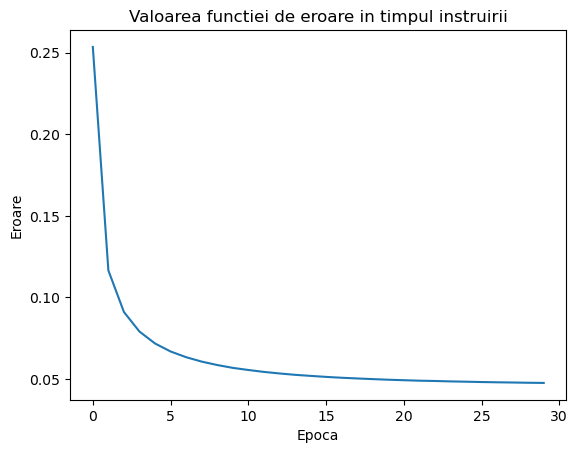

In [23]:
plt.plot(losses)
plt.xlabel('Epoca')
plt.ylabel('Eroare')
plt.title(f'Valoarea functiei de eroare in timpul instruirii')
plt.show()

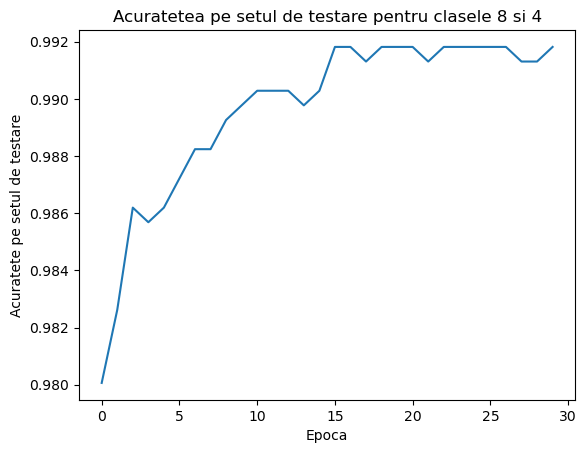

In [24]:
plt.plot(accuracies)
plt.xlabel('Epoca')
plt.ylabel('Acuratete pe setul de testare')
plt.title(f'Acuratetea pe setul de testare pentru clasele {positive_class} si {negative_class}')
plt.show()